In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter


In [5]:
def integrateOverAngles(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]

    energyLow_series = leakOut["energy low [eV]"].loc[leakDF["mesh 1"]["y"] == 1]
    energyLow_vals = [energyLow_series[index] for index in energyLow_series.index]
    scatter_no_angle = []
    energy = []
    for energyLow_val in energyLow_vals:
        angularDistThisEnergy = leakOut.loc[leakOut["energy low [eV]"] == energyLow_val]
        energyHigh_val = list(angularDistThisEnergy["energy high [eV]"])[0]
        if energyLow_val <= 0.01 and energyHigh_val >= 0.01: continue
        scatter_no_angle.append(np.trapz(list(angularDistThisEnergy["mean"])))
        energy.append((energyLow_val+energyHigh_val)*0.5)
    return energy, scatter_no_angle

In [6]:
runs = ['400 No Sab',
        '400 True',
        '400 XS interp 373 423',
        '400 XS interp 350 450',
        '400 XS interp 300 500',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','_') for string in runs]


filters = [100,100]
particles = '1e7'
dfVec = []
for name in names:
    dfVec.append(pd.read_hdf('./Results/Filters__E'+str(filters[0])+
                             '_Space'+str(filters[1])+'/b10_p'+particles+
                             '_'+name+'/results.h5',key='df'))
# df2 = pd.read_hdf('./Results/Filters__E'+str(filters[0])+'_Space'+str(filters[1])+'/b10_p'+particles+'_400_True/results.h5',key='df')
# df3 = pd.read_hdf('./Results/Filters__E'+str(filters[0])+'_Space'+str(filters[1])+'/b10_p'+particles+'_400_Wrong_Dos_800/results.h5',key='df')

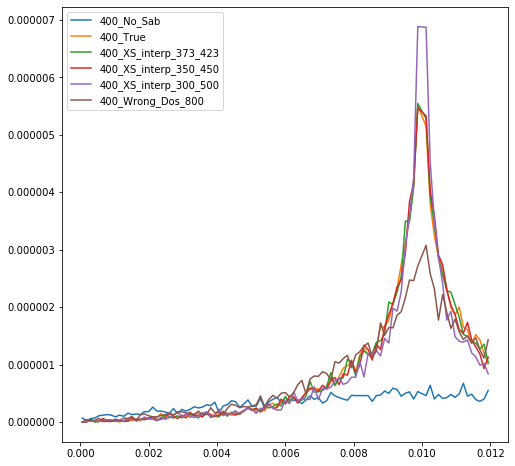

In [7]:
plt.figure(figsize=(8,8))
for i,df in enumerate(dfVec):
    e,s = integrateOverAngles(df)
    plt.plot(e,s,label=names[i])
plt.legend()

In [73]:
def integrateOverEnergy(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]
    yVals = list(dict.fromkeys(list(leakOut["mesh 1"]["y"])))

    spatialVec = []
    tallyVec = []
    for yVal in yVals:
        if yVal == int(len(yVals)*0.5): continue
        y1_series = leakOut.loc[leakOut["mesh 1"]["y"] == yVal]
        eLow = list(y1_series["energy low [eV]"])
        eHigh = list(y1_series["energy high [eV]"])
        eMid = [0.5*(eLow[i]+eHigh[i]) for i in range(len(eLow))]
        tallyVec.append(np.trapz(list(y1_series["mean"]),x=eMid))
    return tallyVec

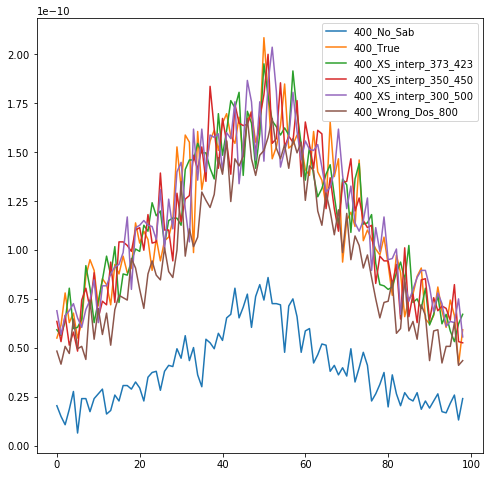

In [74]:
plt.figure(figsize=(8,8))
for i,df in enumerate(dfVec):
    s = integrateOverEnergy(df)
    plt.plot(s,label=names[i])
plt.legend()


In [8]:
def getArray(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]

    firstEntry = leakOut.loc[leakOut["mesh 1"]["x"] == 1].loc[leakOut["mesh 1"]["y"] == 1]
    EVals   = list(firstEntry["energy low [eV]"]) + [list(firstEntry["energy high [eV]"])[-1]]
    eMidVec = [(EVals[i]+EVals[i+1])*0.5 for i in range(len(EVals)-1)]

    array = np.zeros((len(eMidVec),max(list(leakOut["mesh 1"]["y"]))))
    for i,eMid in enumerate(eMidVec):
        E_specific = leakOut.loc[leakOut["energy low [eV]"] < eMid]\
                            .loc[leakOut["energy high [eV]"] > eMid]
        if list(E_specific["energy low [eV]"])[0] <= 0.01 and \
           list(E_specific["energy high [eV]"])[0] >= 0.01: continue
        array[i] = E_specific["mean"]
    return array,eMidVec

In [9]:
def plotArray(array,vmax=None):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    array=gaussian_filter(array, 1.2)

    if vmax:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1],vmin=0,vmax=vmax)
    else:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1])
    plt.ylabel('Energy [eV]')
    plt.xlabel('Space [normalized]')
    desiredEPoints = np.linspace(0.0,1.2,13)
    desiredEPoints_shifted = [2*val/max(desiredEPoints) - 1.0 for val in desiredEPoints]
    desiredEPoints = ['%.1f'%val for val in desiredEPoints]
    ax.set_yticks(desiredEPoints_shifted);
    ax.set_yticklabels(desiredEPoints[::-1]);
    

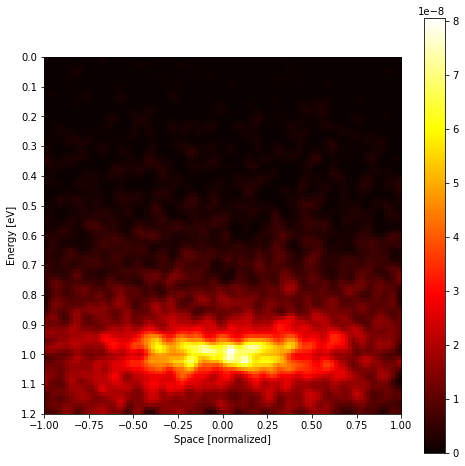

In [10]:
array1,Evals1 = getArray(dfVec[1]); #plotArray(array1)
array2,Evals2 = getArray(dfVec[2]); #plotArray(array2)
# array1,Evals1 = getArray(dfVec[4]); plotArray(array1)
# array1,Evals1 = getArray(dfVec[5]); plotArray(array1)
plotArray(array1)
plt.colorbar()
